In [1]:
import argparse
import glob
import logging
import os
import sys
from os import listdir, sep
from os.path import join, splitext
from pathlib import Path
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as trns
import wandb
from PIL import Image
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.dataset import Dataset
from tqdm import tqdm

os.environ[ "CUDA_VISIBLE_DEVICES" ] = "1"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name GeForce RTX 2080 Ti


In [2]:
class BasicDataset( Dataset ):

    def __init__(
            self,
            images_dir: str,
            masks_dir: str,
            scale: float = 1.0,
            img_suffix: str = '',
            mask_suffix: str = '',
            onlyLabel: bool = False,
            HUSlice: int = 930 ):
        self.images_dir = Path( images_dir )
        self.masks_dir = Path( masks_dir )
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix
        self.img_suffix = img_suffix
        self.hu = HUSlice
        
        label_ids = [
                '_'.join( file.split( '_' )[ :3 ] ) for file in [
                    splitext( file )[ 0 ] for file in listdir( images_dir )
                    if not file.startswith( '.' ) and ( True if mask_suffix == '' else mask_suffix not in file )
                ] if '_1_' in file
            ]

        unlabel_ids = [
                '_'.join( file.split( '_' )[ :3 ] ) for file in [
                    splitext( file )[ 0 ] for file in listdir( images_dir )
                    if not file.startswith( '.' ) and ( True if mask_suffix == '' else mask_suffix not in file )
                ] if '_0_' in file
            ]
        
        random_unlabel_ids = random.sample(unlabel_ids, len(label_ids))
     
        """self.ids = [
            splitext( file )[ 0 ] for file in listdir( images_dir )
            if not file.startswith( '.' ) and ( True if mask_suffix == '' else mask_suffix not in file )
        ]
        self.ids = sorted( [ '_'.join( file.split( '_' )[ :3 ] ) for file in self.ids if '_1_' in file or onlyLabel is False] )"""
        
        if onlyLabel : 
            self.ids = sorted(label_ids + random_unlabel_ids )
        else :
            self.ids = unlabel_ids

        if not self.ids:
            raise RuntimeError( f'No input file found in {images_dir}, make sure you put your images there' )
        logging.info( f'Creating dataset with {len(self.ids)} examples' )
        
        print( f"load {images_dir} with { len( self.ids ) } data, config: onlylabel is { onlyLabel}, HU slice is {HUSlice}")

    def __len__( self ):
        return len( self.ids )

    @classmethod
    def preprocess( cls, pil_img, scale, hu, is_mask ):
        w, h = pil_img.size
        newW, newH = int( scale * w ), int( scale * h )
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize( ( newW, newH ) )
        img_ndarray = np.asarray( pil_img )

        if img_ndarray.ndim == 2 and not is_mask:
            img_ndarray = img_ndarray.reshape( ( 1, newW, newH ) ).clip( hu, hu + 255 ) - hu
        elif not is_mask:
            img_ndarray = img_ndarray.transpose( ( 2, 0, 1 ) )
        elif is_mask :
            img_ndarray = img_ndarray.reshape( ( 1, newW, newH ) )

        #if not is_mask:
        #    img_ndarray = img_ndarray / 255

        return img_ndarray

    @classmethod
    def load( cls, filename ):
        ext = splitext( filename )[ 1 ]
        if ext in [ '.npz', '.npy' ]:
            return Image.fromarray( np.load( filename ) )
        elif ext in [ '.pt', '.pth' ]:
            return Image.fromarray( torch.load( filename ).numpy() )
        else:
            return Image.open( filename )

    def __getitem__( self, idx ):
        name = self.ids[ idx ]
        mask_file = list( self.masks_dir.glob( name + self.mask_suffix + '.*' ) )
        img_file = list( self.images_dir.glob( name + self.img_suffix + '.*' ) )

        assert len( mask_file ) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}\nids:{self.ids}'
        assert len( img_file ) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}\nids:{self.ids}'
        mask = self.load( mask_file[ 0 ] )
        img = self.load( img_file[ 0 ] )

        assert img.size == mask.size, 'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        img = self.preprocess( img, self.scale, self.hu, is_mask=False )
        mask = self.preprocess( mask, self.scale, self.hu, is_mask=True )

        return [
            torch.as_tensor( img.copy() ).float().contiguous(),
            torch.as_tensor( mask.copy() ).long().contiguous()
        ]
#end

In [3]:
class DatasetVGHTC( BasicDataset ):

    def __init__( self, dataset_dir: str, split: str, scale: float = 1, onlyLabel: bool = False, HUSlice: int = 930 ):
        super().__init__(
            images_dir=join( dataset_dir, split ),
            masks_dir=join( dataset_dir, split ),
            scale=scale,
            img_suffix='_ct',
            mask_suffix='_mask',
            onlyLabel=onlyLabel,
            HUSlice=HUSlice )
#end

In [4]:
"""# Create train/valid datasets
train_set = DatasetVGHTC( dataset_dir='./dataset/', split='train', scale=0.5, onlyLabel=True,  HUSlice=960 )
valid_set = DatasetVGHTC( dataset_dir='./dataset/', split='test', scale=0.5, onlyLabel=True,  HUSlice=960 )
#%%
# Create train/valid loaders
train_loader = DataLoader( dataset=train_set, batch_size=16, shuffle=False, num_workers=4 )
valid_loader = DataLoader( dataset=valid_set, batch_size=16, shuffle=False, num_workers=4 )
#%%
# Get images and labels in a mini-batch of train_loader
for batch in valid_loader:
    imgs = batch[ 'image' ]
    msks = batch[ 'mask' ]
    print( 'Size of image:', imgs.size() )  # batch_size * 3 * 224 * 224
    print( 'Type of image:', imgs.dtype )  # float32
    print( 'Size of masks:', msks.size() )  # batch_size
    print( 'Type of masks:', msks.dtype )  # int64(long)
    for i in range( len( imgs ) ):
        plot_img_and_mask( imgs[ i ], msks[ i ] )"""
        
train_set = DatasetVGHTC( dataset_dir='./dataset/', split='train', scale=0.5, onlyLabel=True,  HUSlice=960 )
val_set = DatasetVGHTC( dataset_dir='./dataset/', split='test', scale=0.5, onlyLabel=True,  HUSlice=960 )

image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
}

load ./dataset/train with 468 data, config: onlylabel is True, HU slice is 960
load ./dataset/test with 88 data, config: onlylabel is True, HU slice is 960


In [5]:
next(iter(dataloaders['train']))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [6]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())
    
    self.conv1 = nn.Conv2d( 1 , 3 , (3,3), padding = 1)
    
    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(self.conv1(input))
    x_original = self.conv_original_size1(x_original)

    
    layer0 = self.layer0( self.conv1(input))
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = ResNetUNet(1)
model = model.to(device)

device cuda


In [8]:
model

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [9]:
from torchsummary import summary
summary(model, input_size=(1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 256, 256]              30
            Conv2d-2         [-1, 64, 256, 256]           1,792
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
            Conv2d-6          [-1, 3, 256, 256]              30
            Conv2d-7         [-1, 64, 128, 128]           9,408
            Conv2d-8         [-1, 64, 128, 128]           9,408
       BatchNorm2d-9         [-1, 64, 128, 128]             128
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
             ReLU-12         [-1, 64, 128, 128]               0
        MaxPool2d-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

In [10]:
from collections import defaultdict
import torch.nn.functional as F

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target.float())

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

In [11]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time

num_class = 1
model = ResNetUNet(num_class).to(device)

# freeze backbone layers
for l in model.base_layers:
  for param in l.parameters():
    param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train: bce: 0.185251, dice: 0.994830, loss: 0.590041
LR 0.0001
val: bce: 0.047262, dice: 0.984689, loss: 0.515975
saving best model to checkpoint.pth
0m 9s
Epoch 1/9
----------
train: bce: 0.038771, dice: 0.981457, loss: 0.510114
LR 0.0001
val: bce: 0.031492, dice: 0.977636, loss: 0.504564
saving best model to checkpoint.pth
0m 9s
Epoch 2/9
----------
train: bce: 0.041493, dice: 0.875497, loss: 0.458495
LR 0.0001
val: bce: 0.395695, dice: 0.503617, loss: 0.449656
saving best model to checkpoint.pth
0m 9s
Epoch 3/9
----------
train: bce: 0.101467, dice: 0.514344, loss: 0.307905
LR 0.0001
val: bce: 0.089914, dice: 0.515946, loss: 0.302930
saving best model to checkpoint.pth
0m 9s
Epoch 4/9
----------
train: bce: 0.053516, dice: 0.504912, loss: 0.279214
LR 0.0001
val: bce: 0.070908, dice: 0.541816, loss: 0.306362
0m 8s
Epoch 5/9
----------
train: bce: 0.047738, dice: 0.453004, loss: 0.250371
LR 0.0001
val: bce: 0.159674, dice: 0.488465, loss: 0.324070
0m 8s
Epoch 6/9


In [13]:
def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  inp = (inp * 255).astype(np.uint8)

  return inp

In [60]:
def pred_net( net, device, batch_size: int = 16, img_scale: float = 0.5 ):
    # 1. Create dataset
    pred_set = DatasetVGHTC( dataset_dir='./dataset/', split='test', scale=img_scale, onlyLabel=True, HUSlice=930 )

    # 2. number of dataset
    n_pred = len( pred_set )

    # 3. Create data loaders
    pred_loader = DataLoader( dataset=pred_set, batch_size=batch_size, shuffle=False, num_workers=4 )

    # 5. Begin predict
    net.eval()
    num_val_batches = len( pred_loader )
    dice_score = 0

    # iterate over the validation set
    for batch in tqdm( pred_loader, total=num_val_batches, desc='Validation round', unit='batch', leave=False ):
        imageO, mask_trueO = batch
        image, mask_true = batch
        # move images and labels to correct device and type
        image = image.to( device=device, dtype=torch.float32 )
        mask_true = mask_true.to( device=device, dtype=torch.long )

        with torch.no_grad():
            # predict the mask
            mask_pred = mask_pred_copy = net( image )

            # convert to one-hot format
            
            mask_pred = ( F.sigmoid( mask_pred ) > 0.5 ).float()
            # compute the Dice score
            """dice_score += dice_coeff( mask_pred, mask_true, reduce_batch_first=False )
            else:
                mask_pred = F.one_hot( mask_pred.argmax( dim=1 ), net.n_classes ).permute( 0, 3, 1, 2 ).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff( mask_pred[ :, 1:, ...], mask_true[ :, 1:, ...], reduce_batch_first=False )"""

            for i in range( len( image ) ):
                fig = plt.figure(figsize = (16 ,4))
                plt.subplot( 1, 4, 1 )
                plt.imshow( imageO[ i ][0, :, :] )
                plt.title( 'ct' )

                plt.subplot( 1, 4, 2 )
                plt.imshow( mask_trueO[ i ][0, :, :] )
                plt.title( 'ground-truth' )

                plt.subplot( 1, 4, 3 )
                plt.imshow( mask_pred.cpu()[ i ][0, :, :] )
                plt.title( 'pred' )
                
                plt.subplot( 1, 4, 4 )
                plt.imshow( np.equal(np.asarray(mask_pred.cpu()[ i ][0, :, :]) , np.asarray(mask_trueO[ i ][0, :, :]) ) & np.equal(np.asarray(mask_trueO[ i ][0, :, :]), np.ones(mask_trueO[ i ][0, :, :].shape)))
                plt.title( 'Intersection' )
    net.train()

load ./dataset/test with 88 data, config: onlylabel is True, HU slice is 930


Validation round:  17%|█▋        | 1/6 [00:01<00:06,  1.26s/batch]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


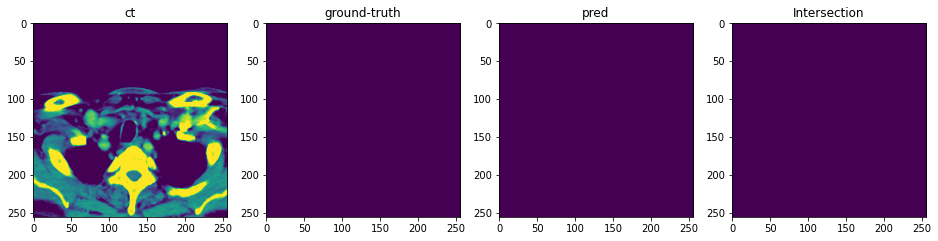

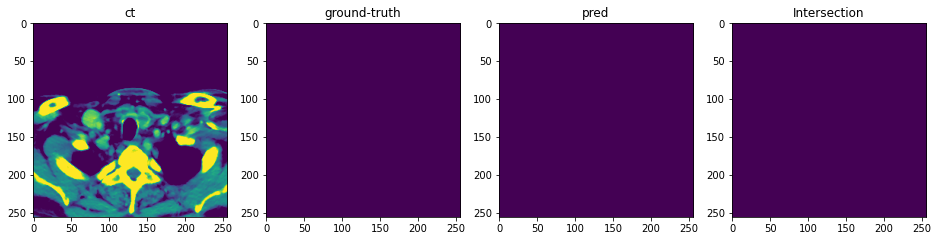

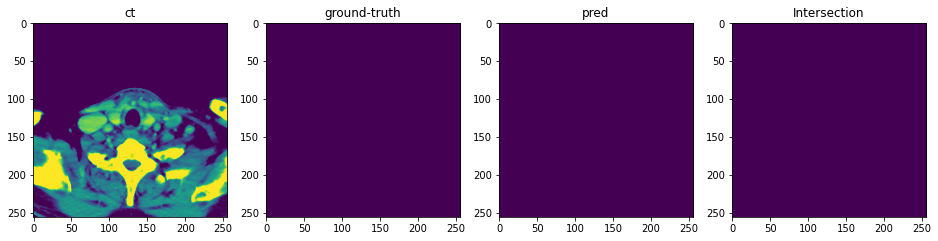

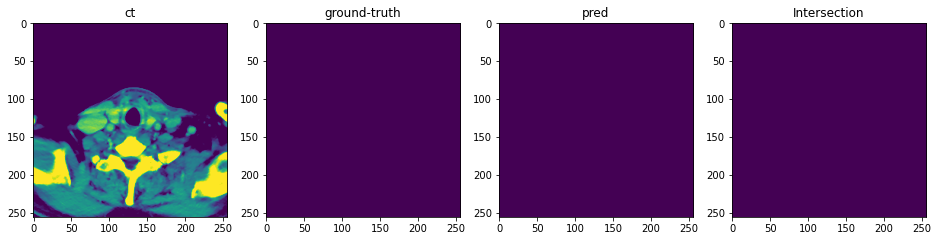

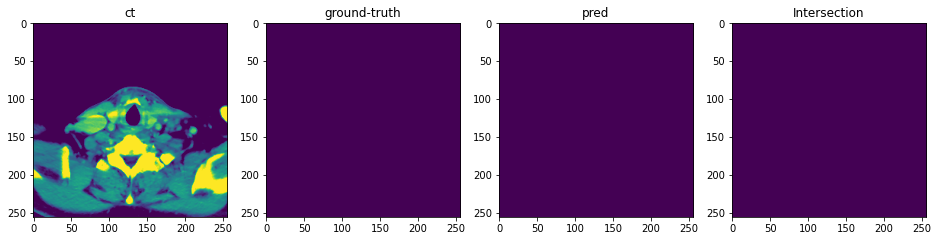

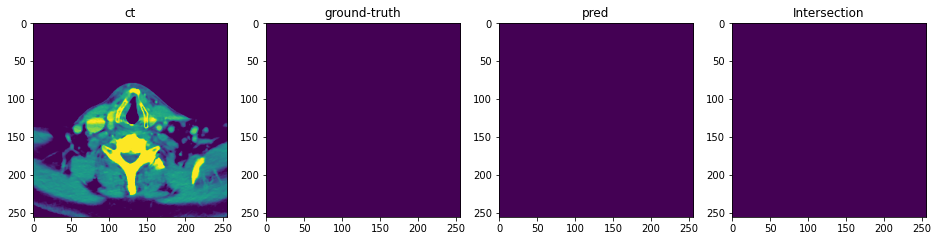

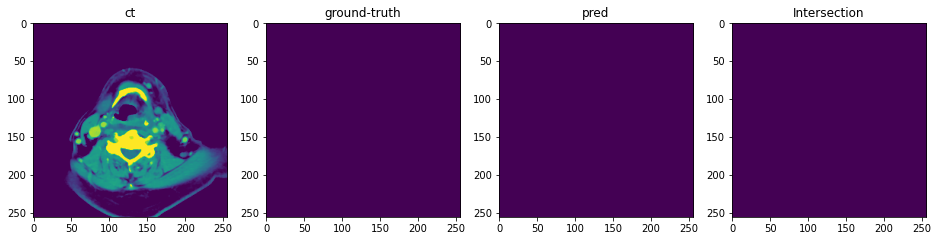

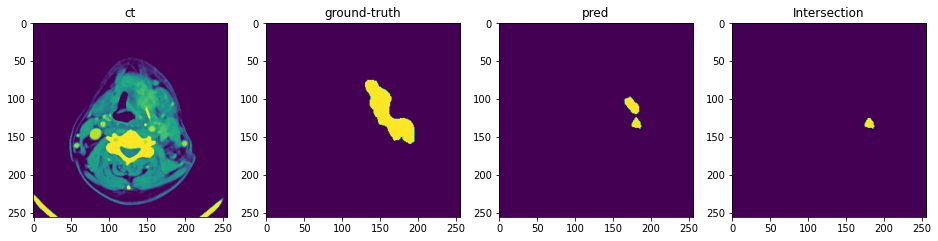

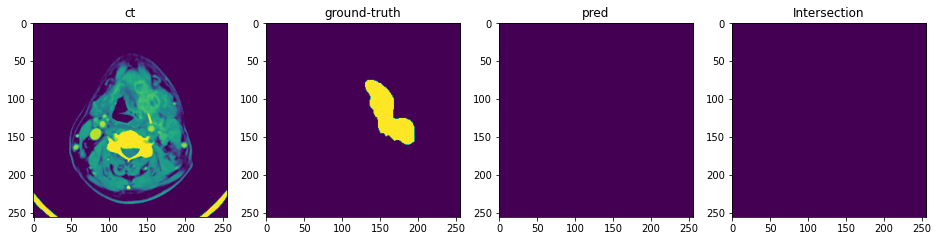

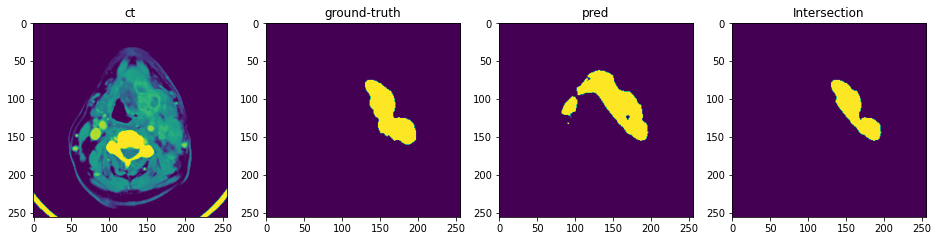

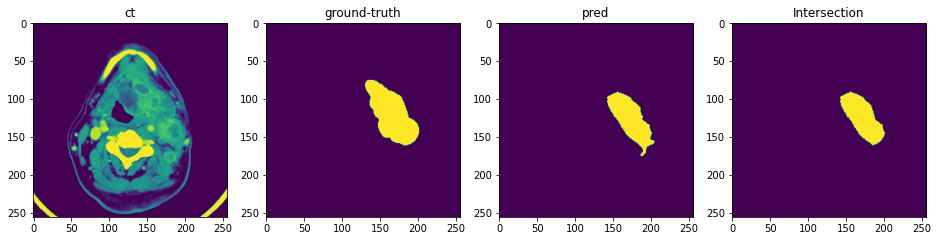

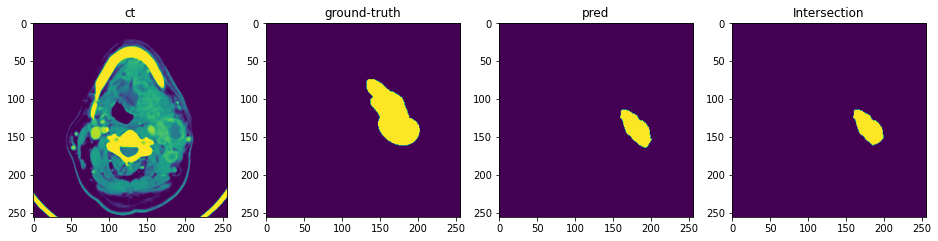

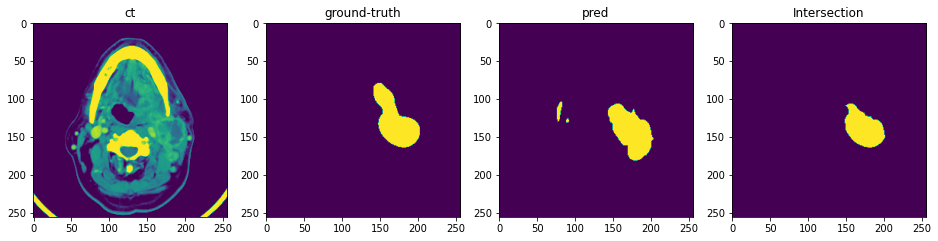

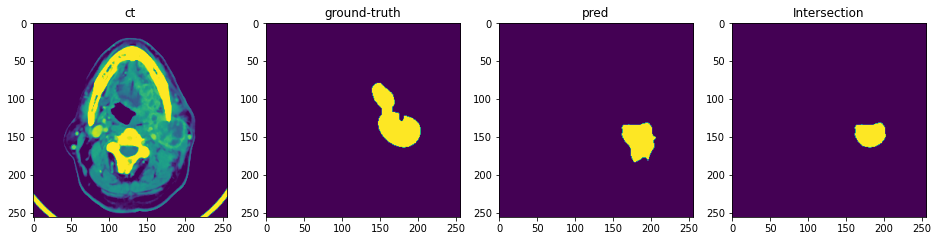

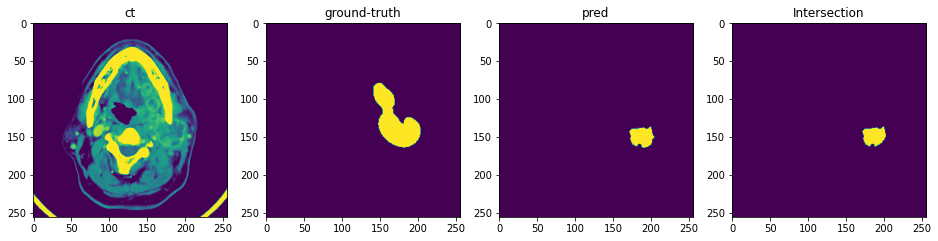

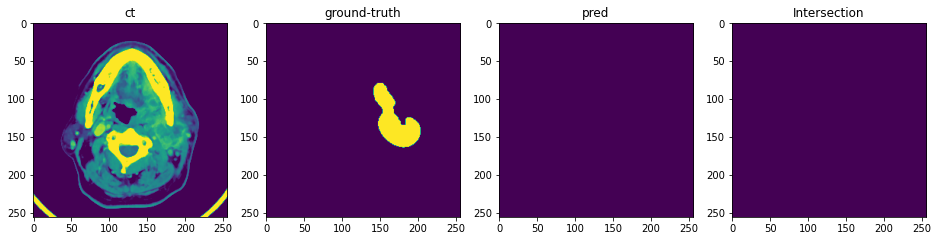

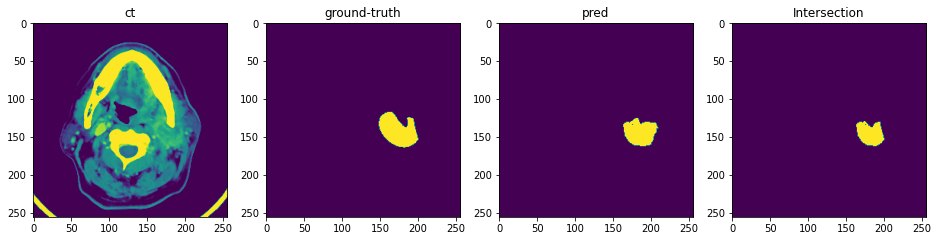

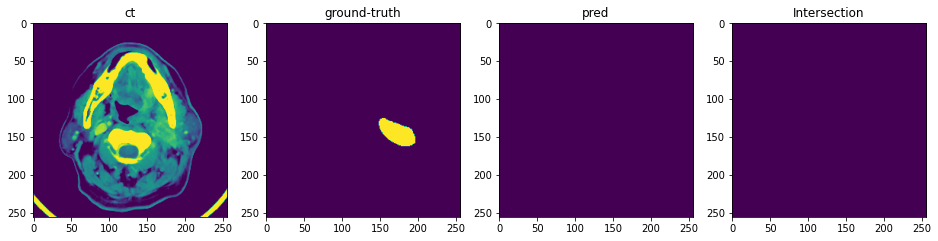

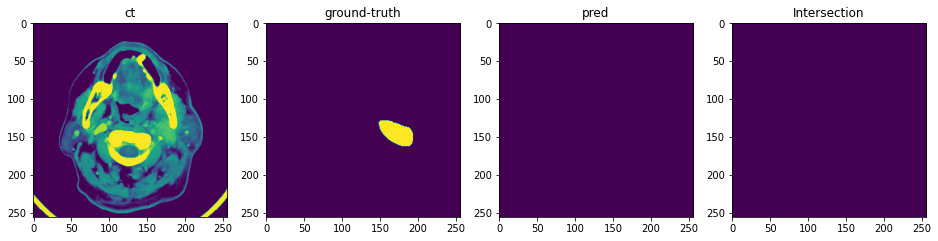

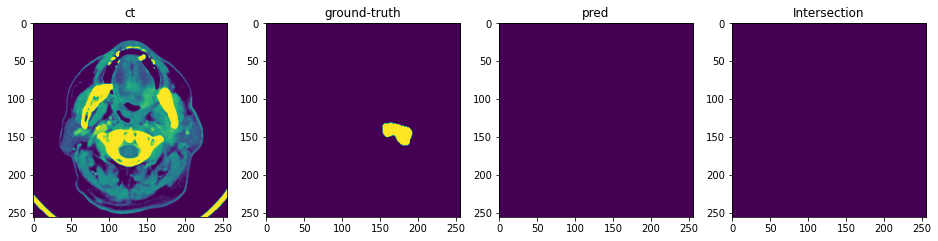

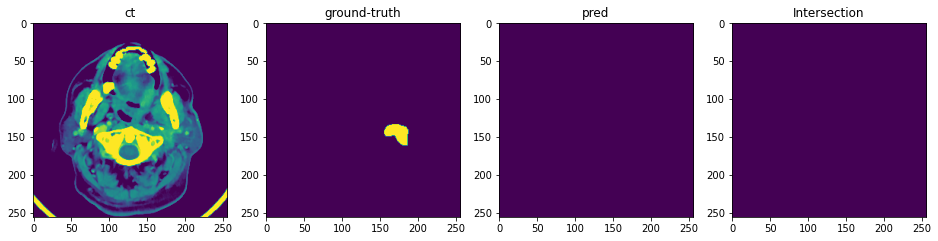

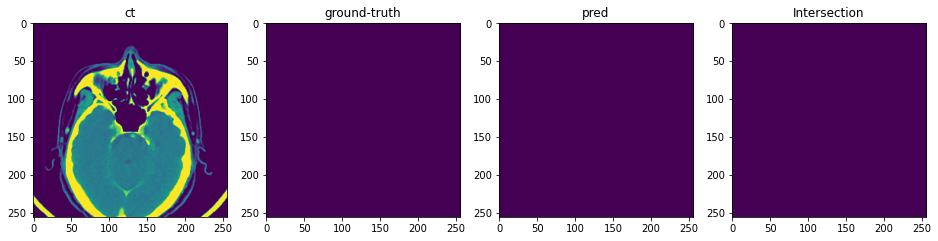

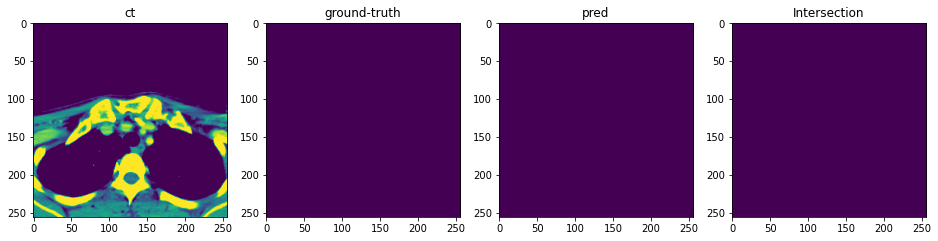

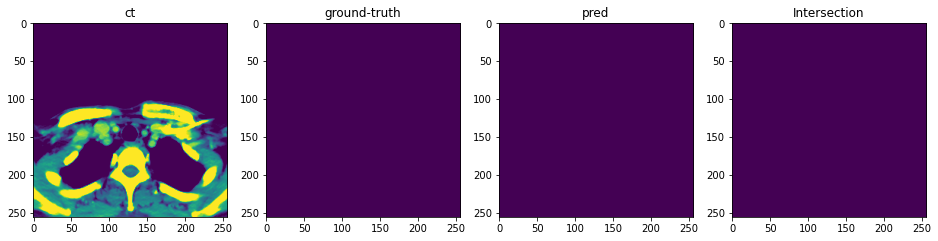

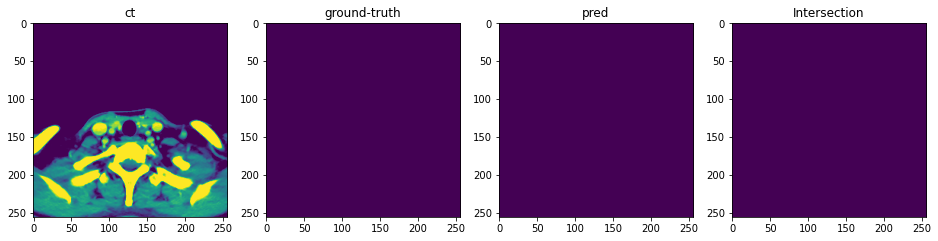

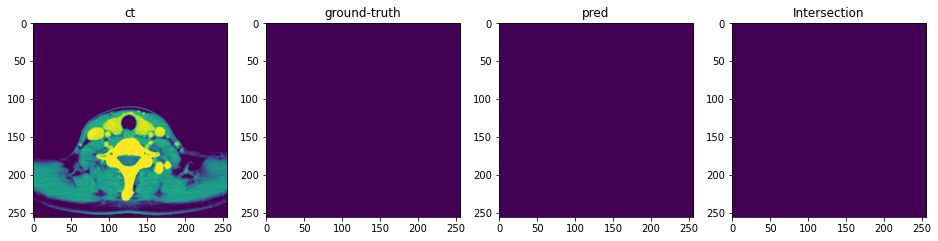

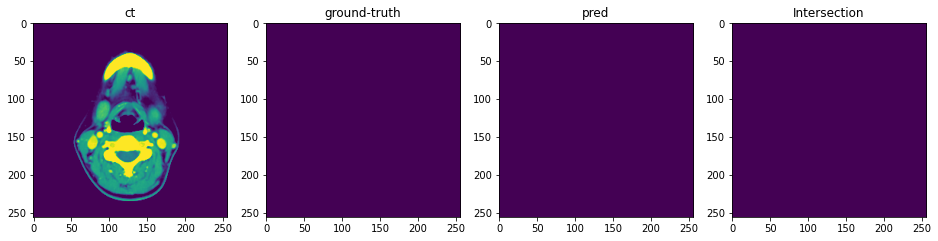

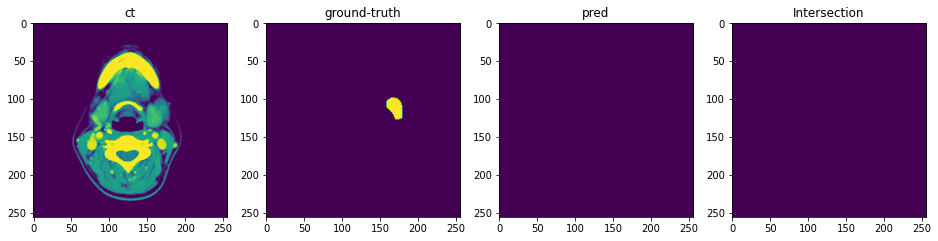

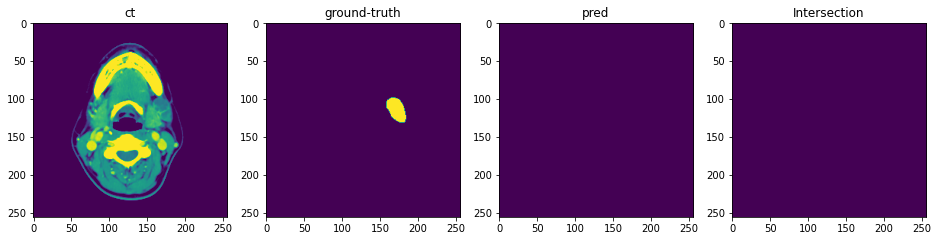

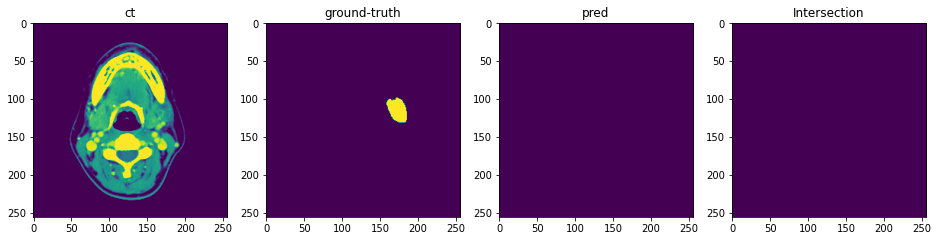

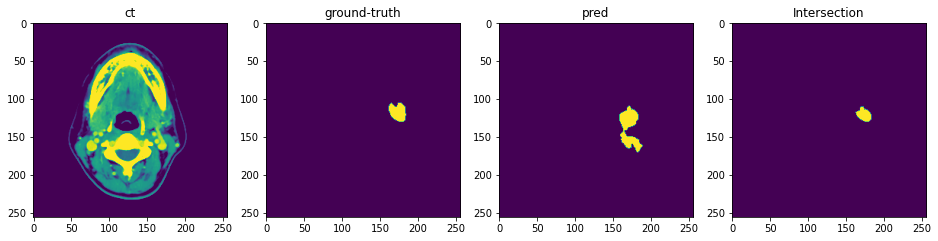

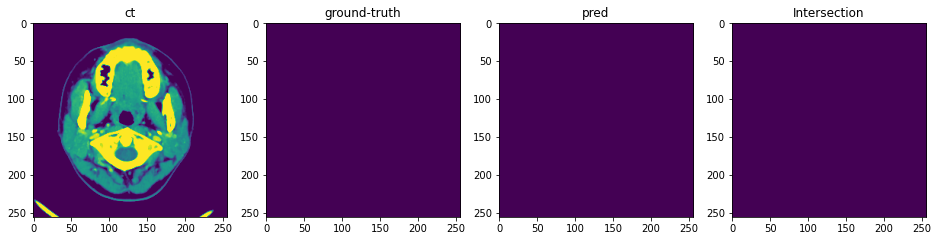

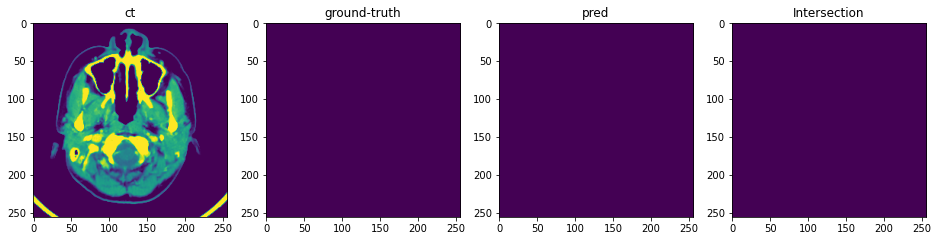

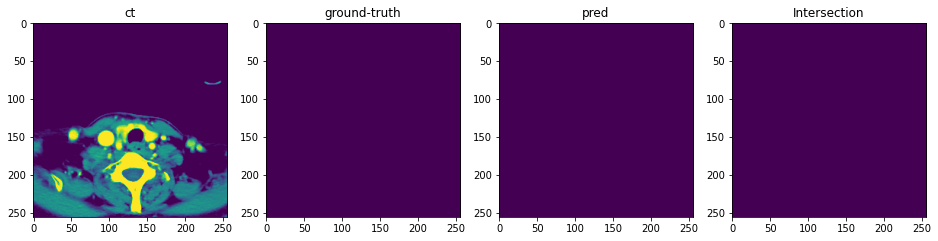

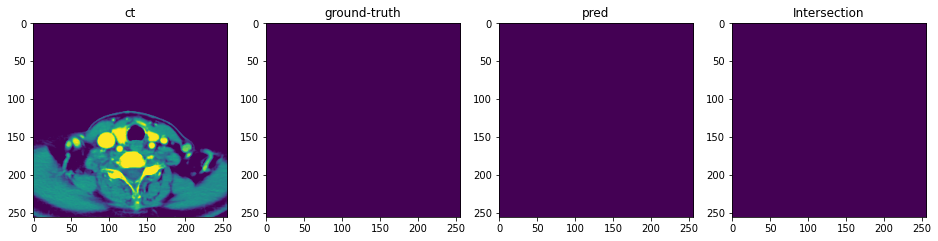

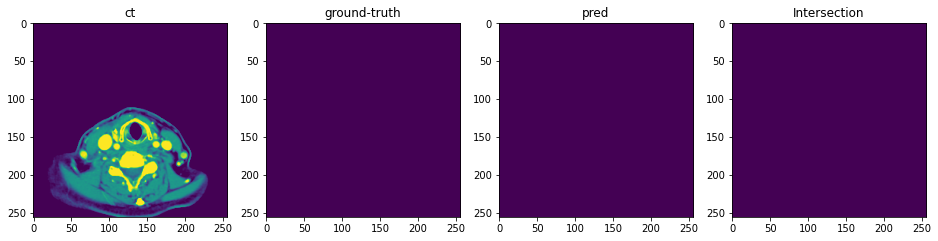

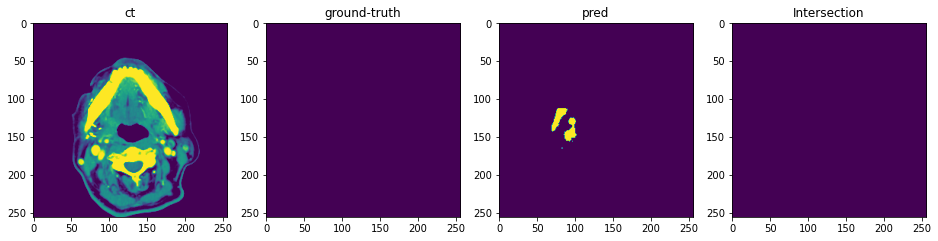

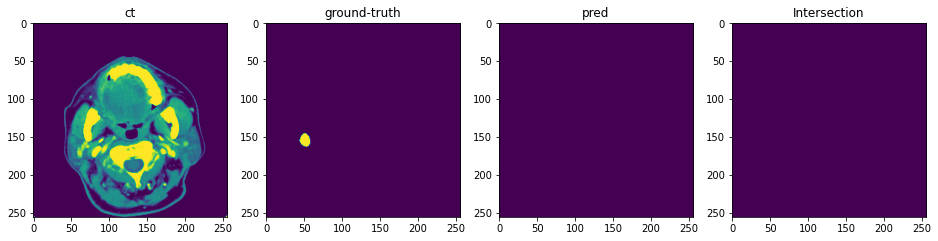

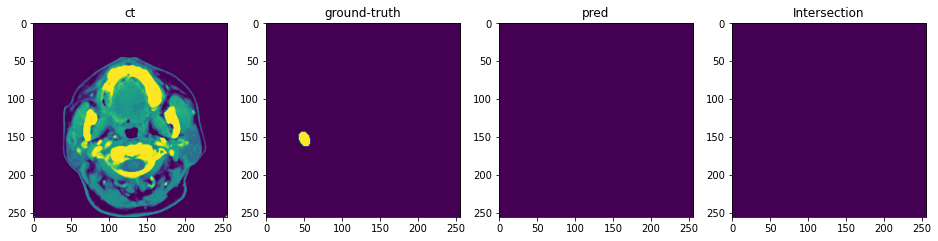

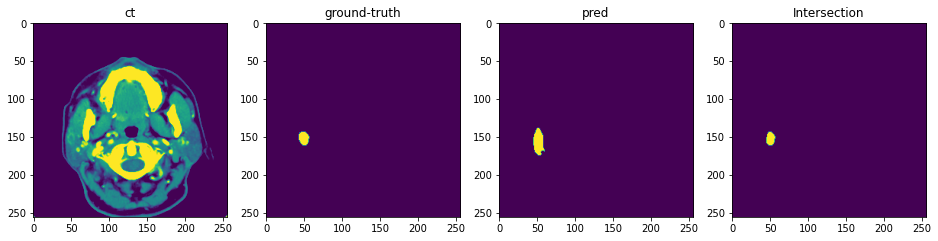

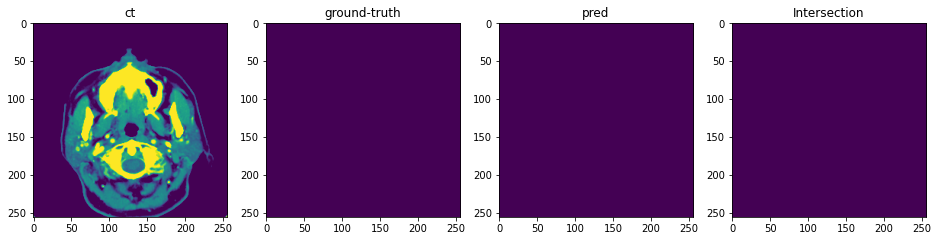

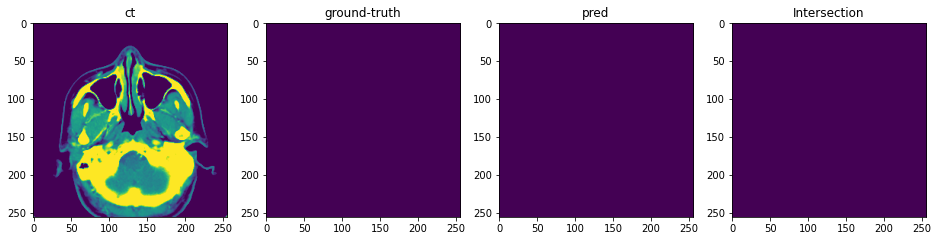

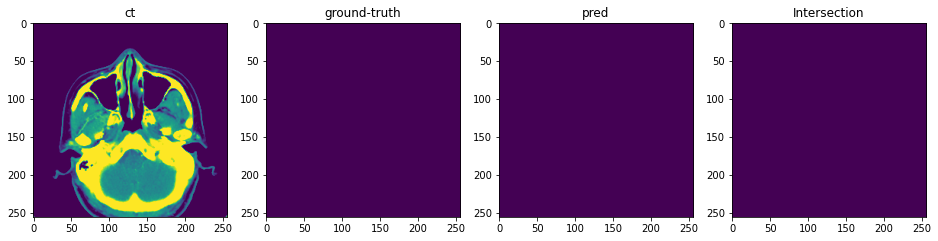

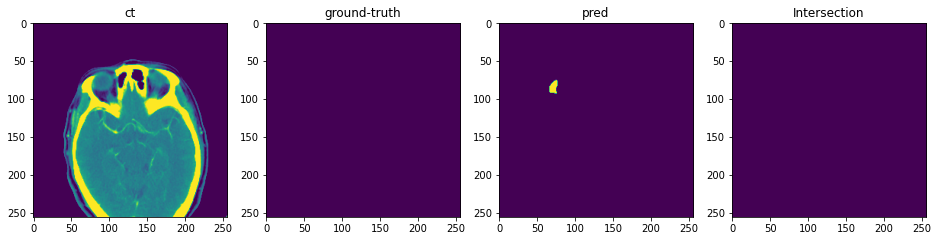

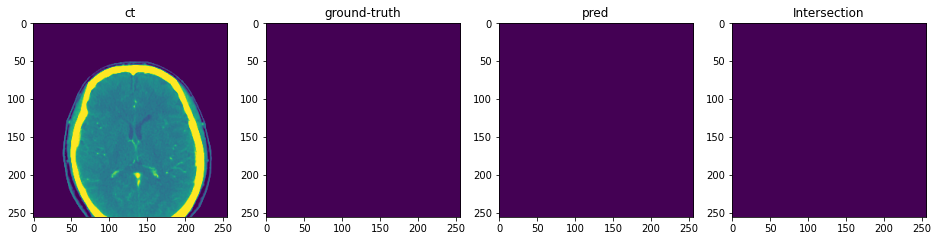

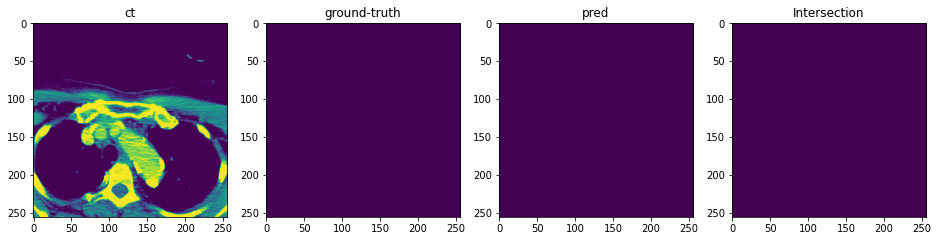

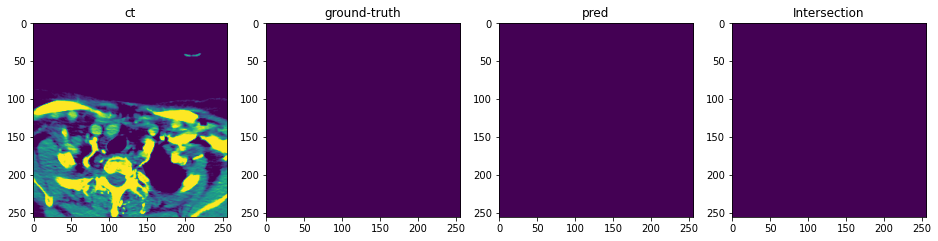

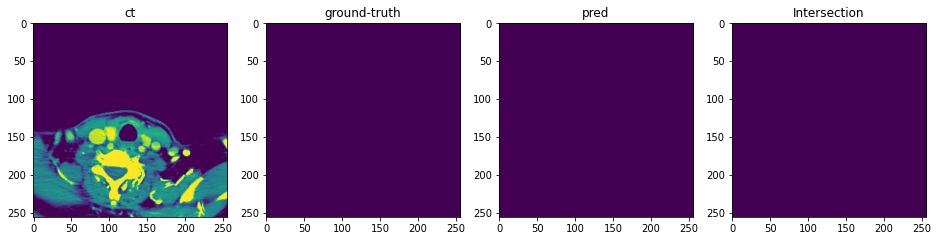

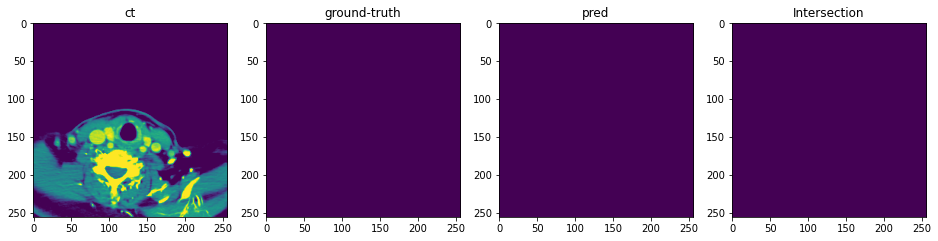

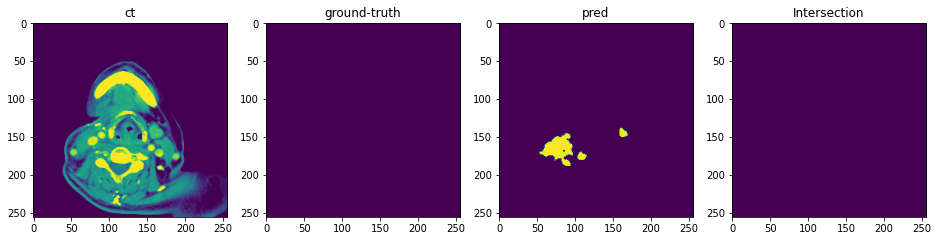

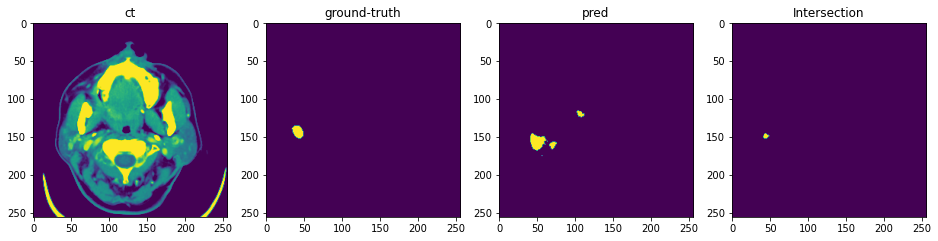

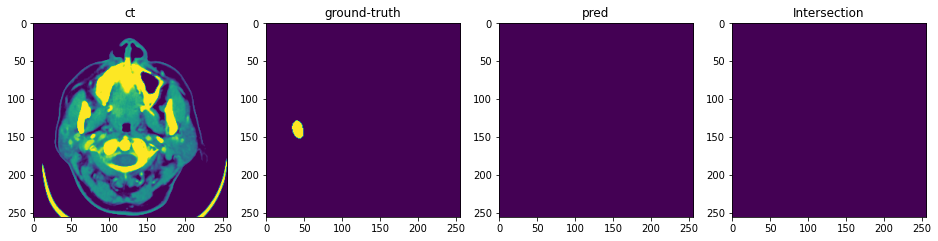

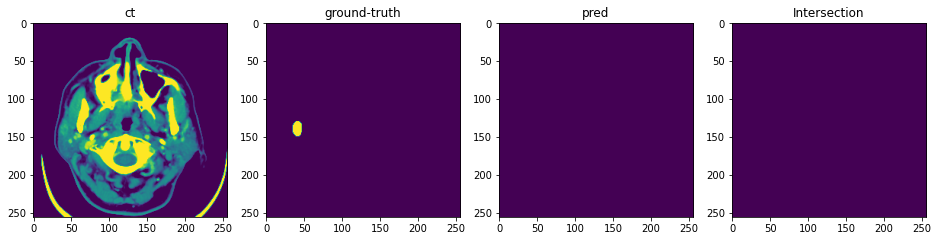

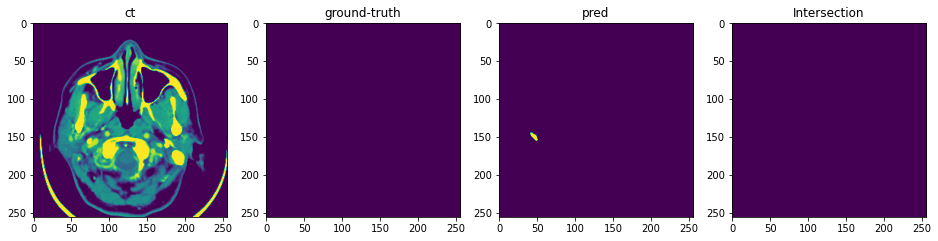

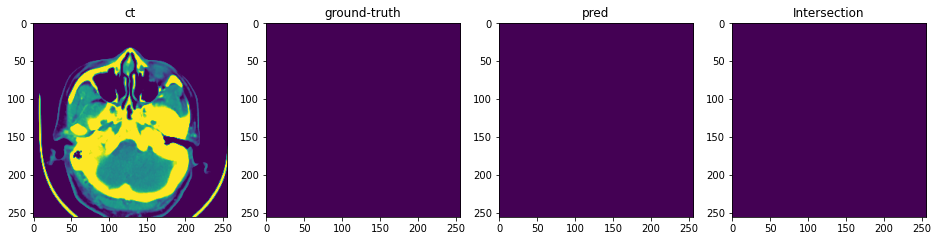

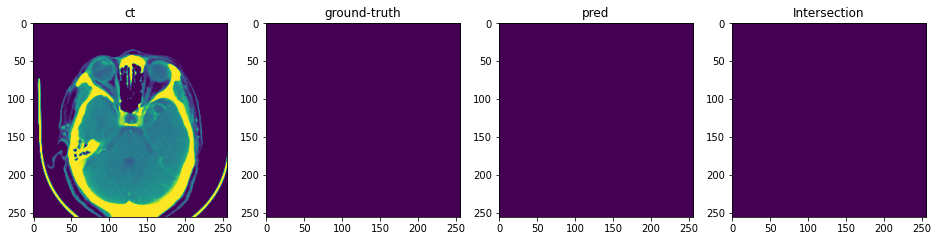

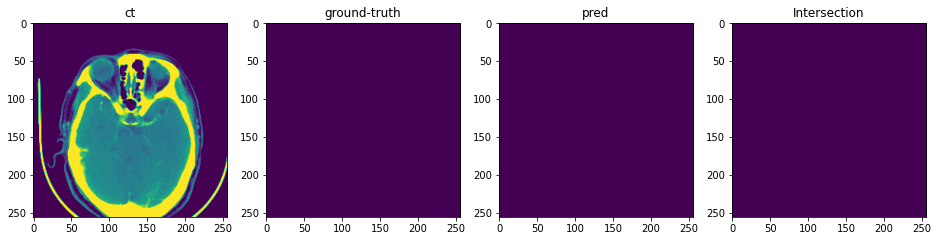

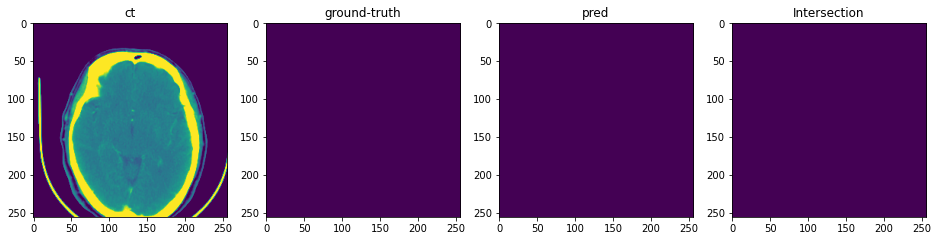

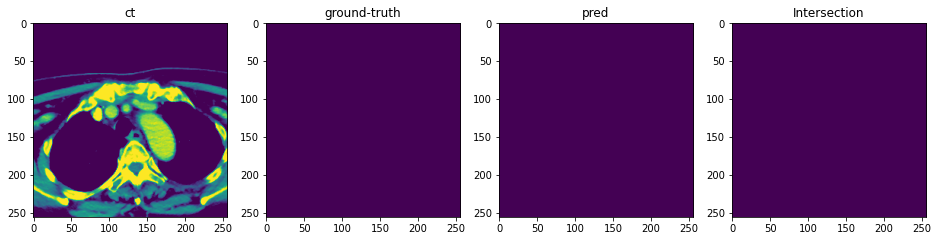

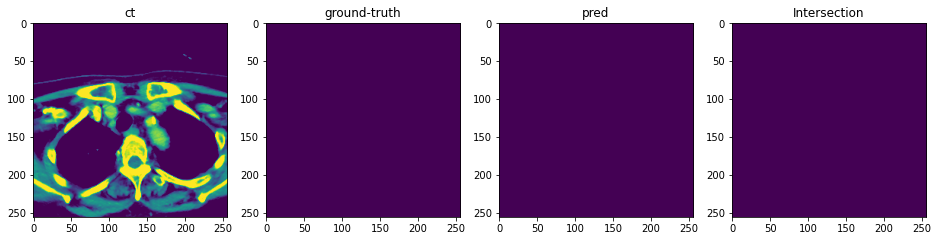

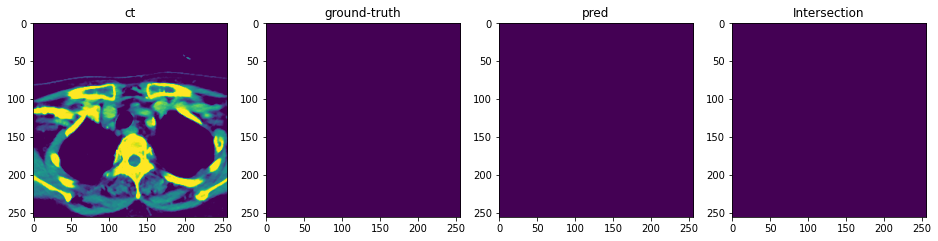

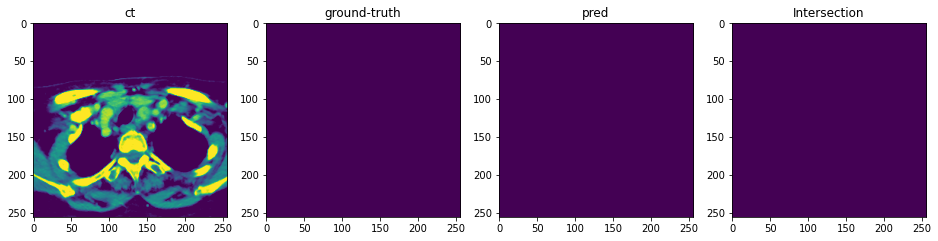

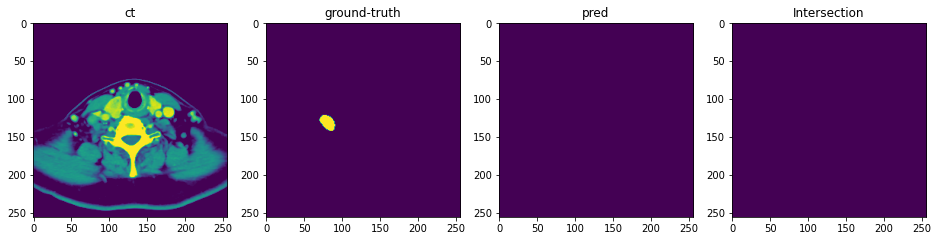

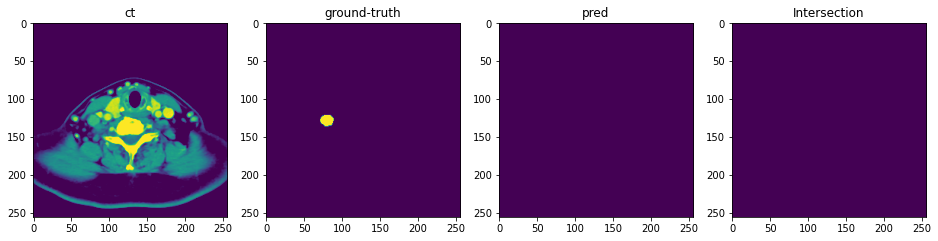

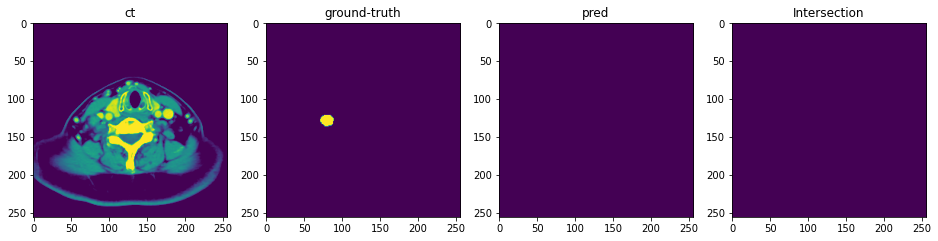

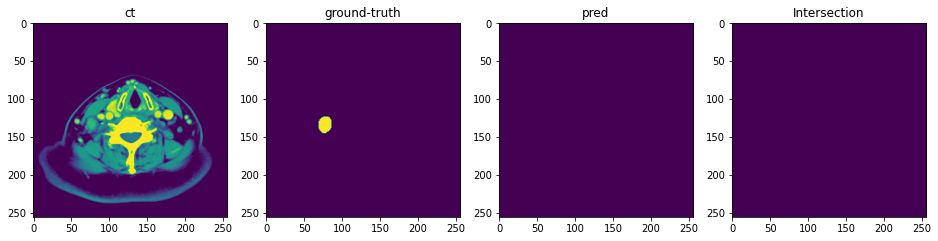

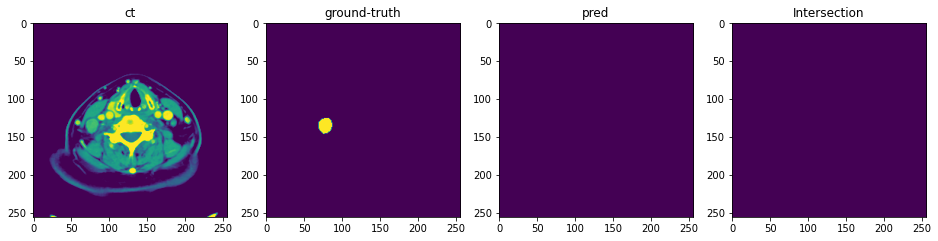

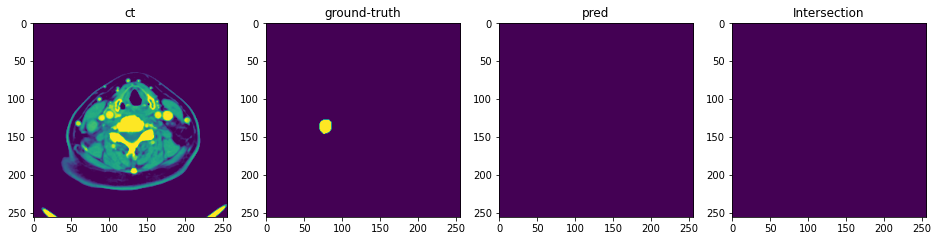

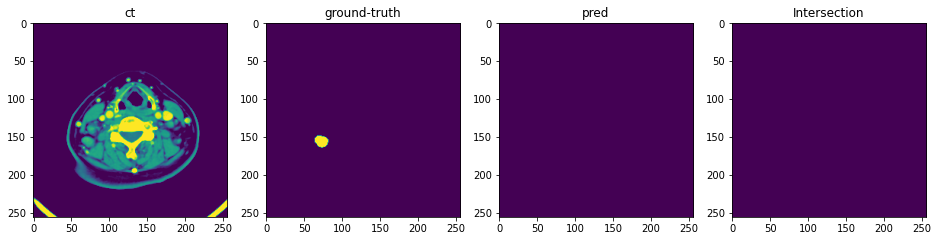

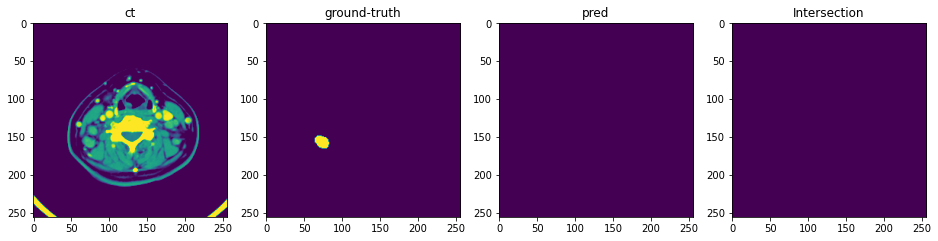

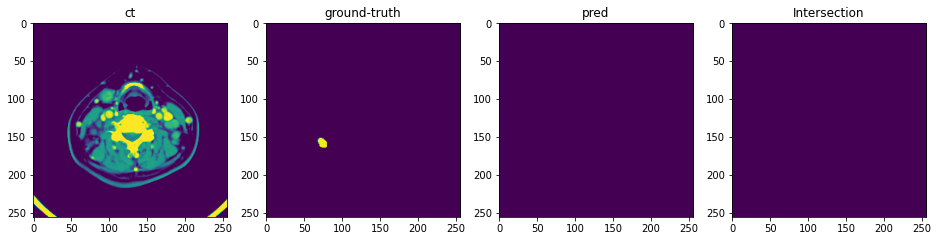

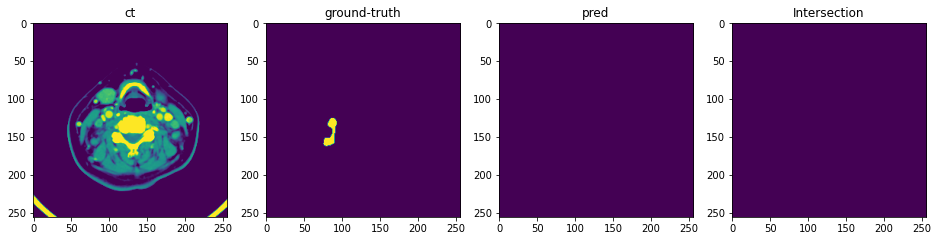

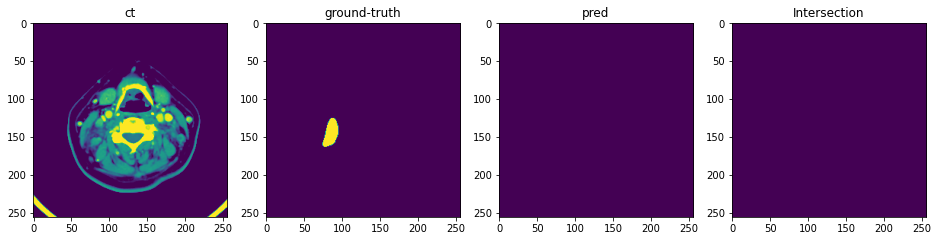

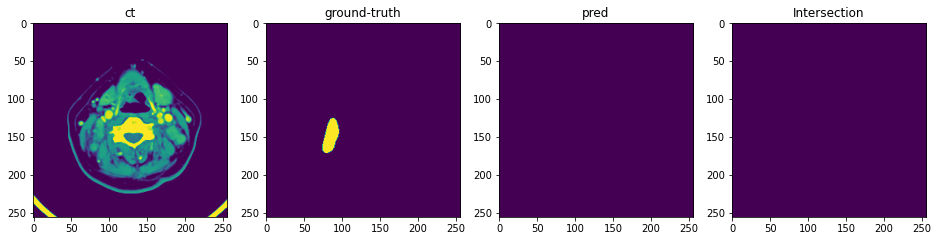

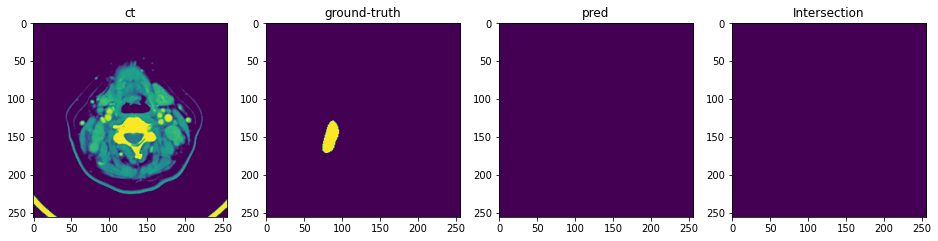

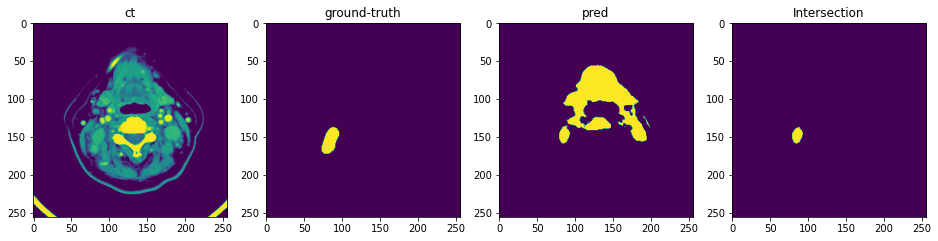

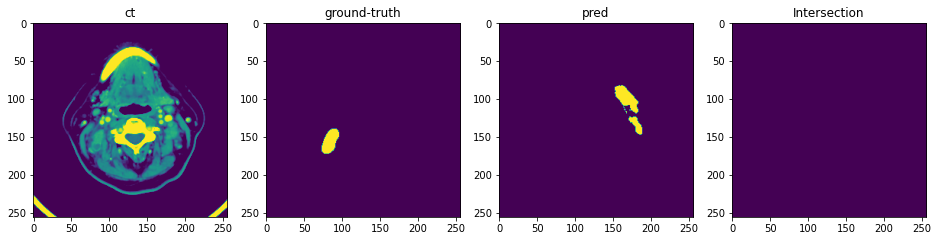

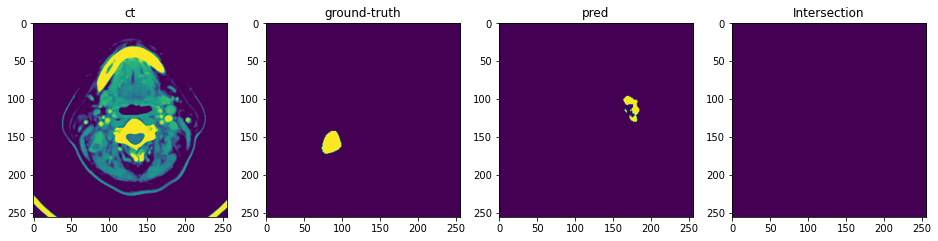

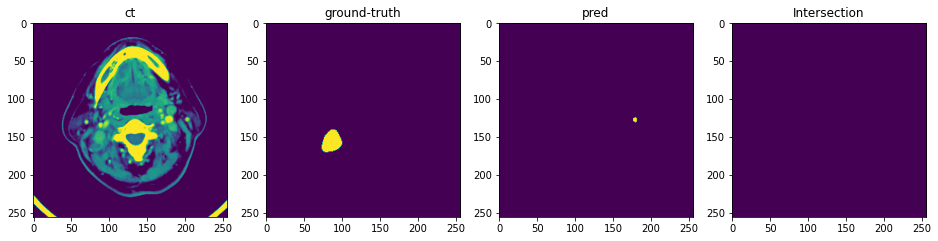

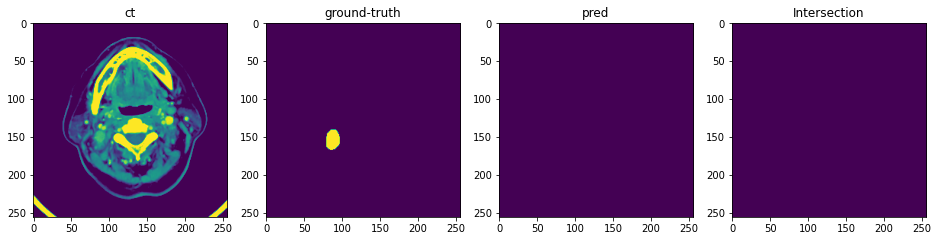

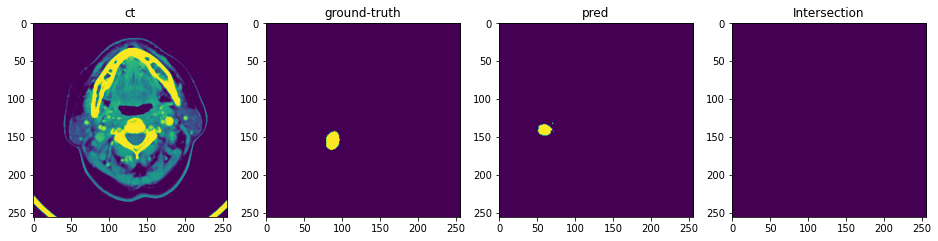

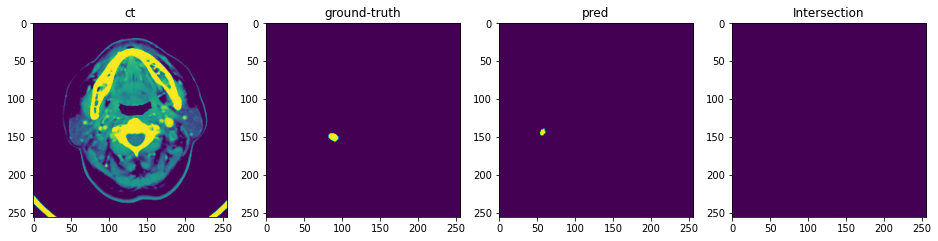

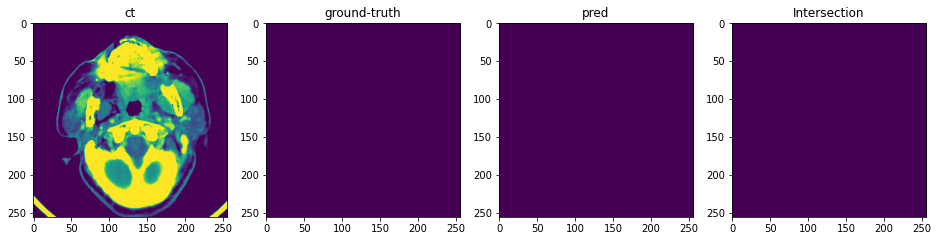

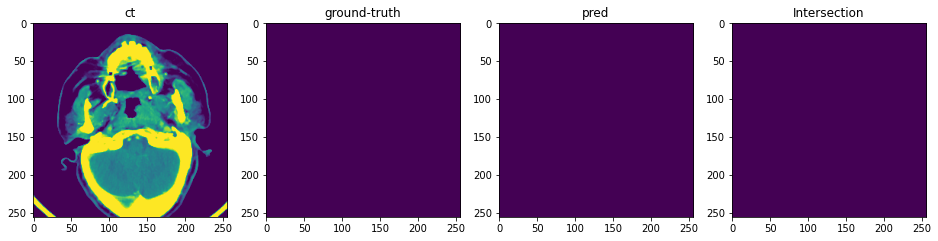

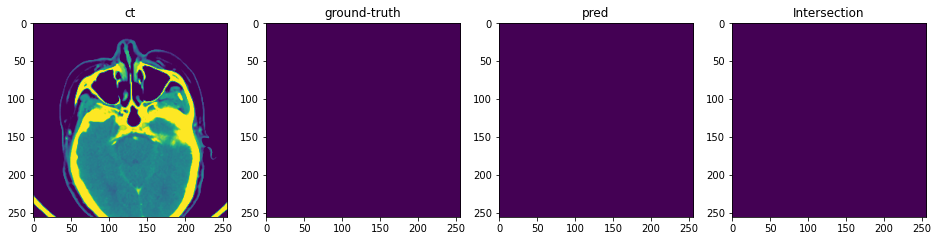

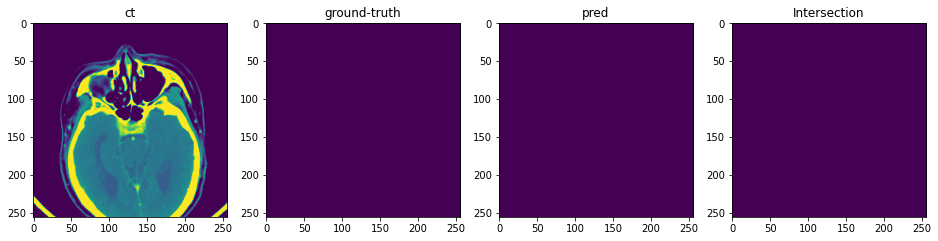

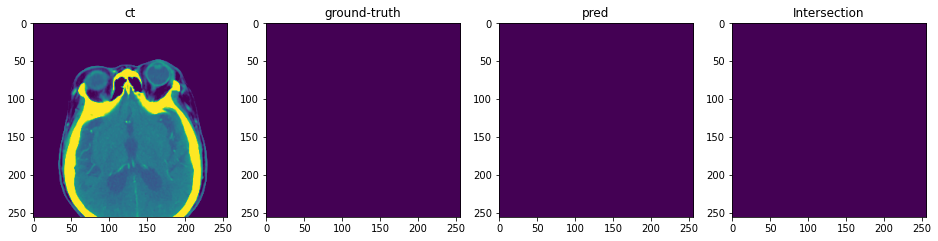

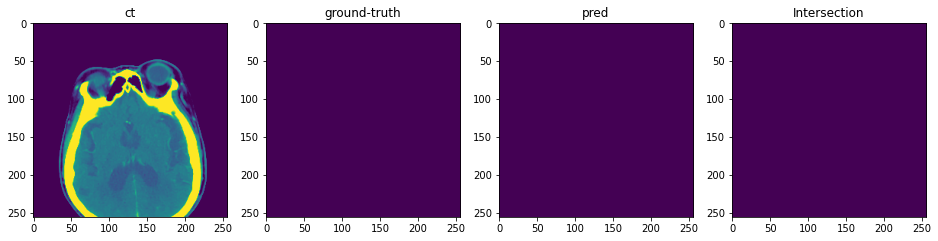

In [61]:
pred_net( model, device, batch_size=16, img_scale=0.5 )

In [17]:
"""import math

def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[0,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

model.eval()   # Set model to the evaluation mode

# Create a new simulation dataset for testing
test_dataset = DatasetVGHTC( dataset_dir='./dataset/', split='test', scale=0.5, onlyLabel=False,  HUSlice=960 )
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred.shape', pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred]"""

load ./dataset/test with 264 data, config: onlylabel is False, HU slice is 960
inputs.shape torch.Size([3, 1, 256, 256])
labels.shape torch.Size([3, 1, 256, 256])
pred.shape (3, 1, 256, 256)


IndexError: index 85 is out of bounds for axis 0 with size 85

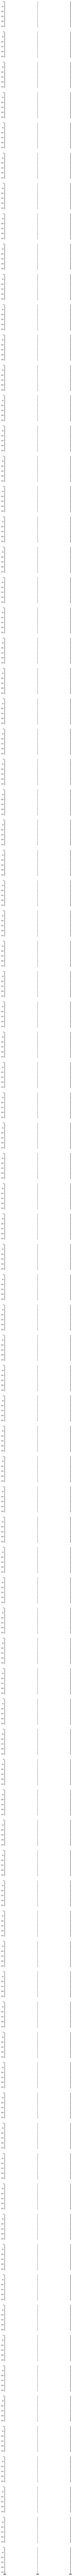

In [27]:
"""from functools import reduce
def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])
        
def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))
    plot_img_array(np.array(flatten_list[0]), ncol=len(img_arrays))
    
plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])"""